# OSIRIS-REx: particle size frequency distribution for OREX-800107-0 using size characteristics from ilastik
OREX-800107-0 is a 6.4-gram aggregate sample that contains approximately 1.5 million grains. The parent sample was OREX-800013-0.
This code analyzes the particle size frequency distribution (PSFD) using the outputs from the image processing software, ilastik. We trained a Random Forest machine learning algorithm using user annotations to process the XCT data. The segmentation from ilastik is loaded into this code and we use multiple Python libraries to find the segmented particles within the processed data. These isolated islands of voxels are analyzed to find the longest axis of the particle and then plot the PSFD.

In [126]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import skimage                            # used for image processing
from scipy import ndimage                 # used to label all the grains
import os                                 # used to interact with operating systems
from scipy.spatial.distance import pdist  # pdist = pairwise distances
from scipy.ndimage import find_objects
from tabulate import tabulate
from numba import jit, njit, prange
from scipy.optimize import curve_fit      # used for power law plotting
import pandas as pd

Load in the ilastik segmentation:
--------------------------------

In [4]:
# assign variables to outputs from Ilastic

# initialize an numpy array for data
# NOTE: data may be interpreted in y, x, z
cube = np.zeros((1384, 1390, 1751), dtype='int8')
# loop through every slice in the xy plane
for i in range(0,1719):
    # define a path to the ilastik output folder
    data = r'C:\\Users\\savan\\OREX-800107-0_ilastik_segment' + f'/OREX-800107-0_ilastik_segment_{i:04d}' + '.tif'
    # assign data to an np.ndarray
    cube[:,:,i] = plt.imread(data)
    # progress check:
    if i % 10 == 0:
       print(i, end='\r')
print('done')

done


In [5]:
# determine the voxel count of every class
print(f'Phase 1 (particle): {np.sum(cube==1): 0.3g} voxels')
print(f'Phase 2 (matrix): {np.sum(cube==2): 0.3g} voxels')
print(f'Phase 3 (vessel): {np.sum(cube==3): 0.3g} voxels')

Phase 1 (particle):  7.26e+08 voxels
Phase 2 (matrix):  2.04e+09 voxels
Phase 3 (vessel):  5.37e+08 voxels


Evaluate the particle mask by plotting z-slices:
--------------------------------------------

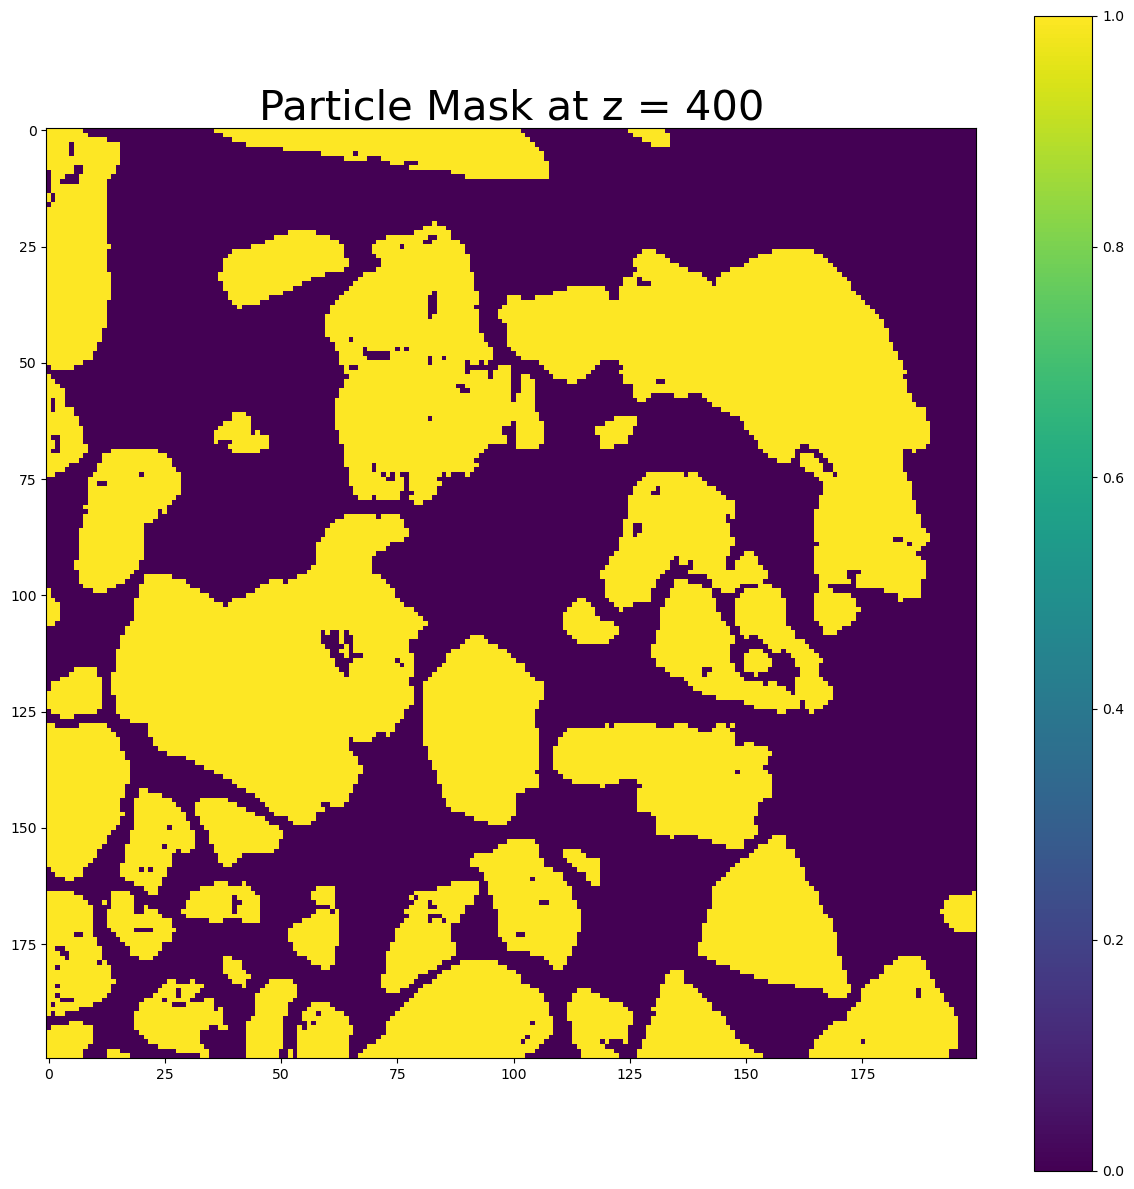

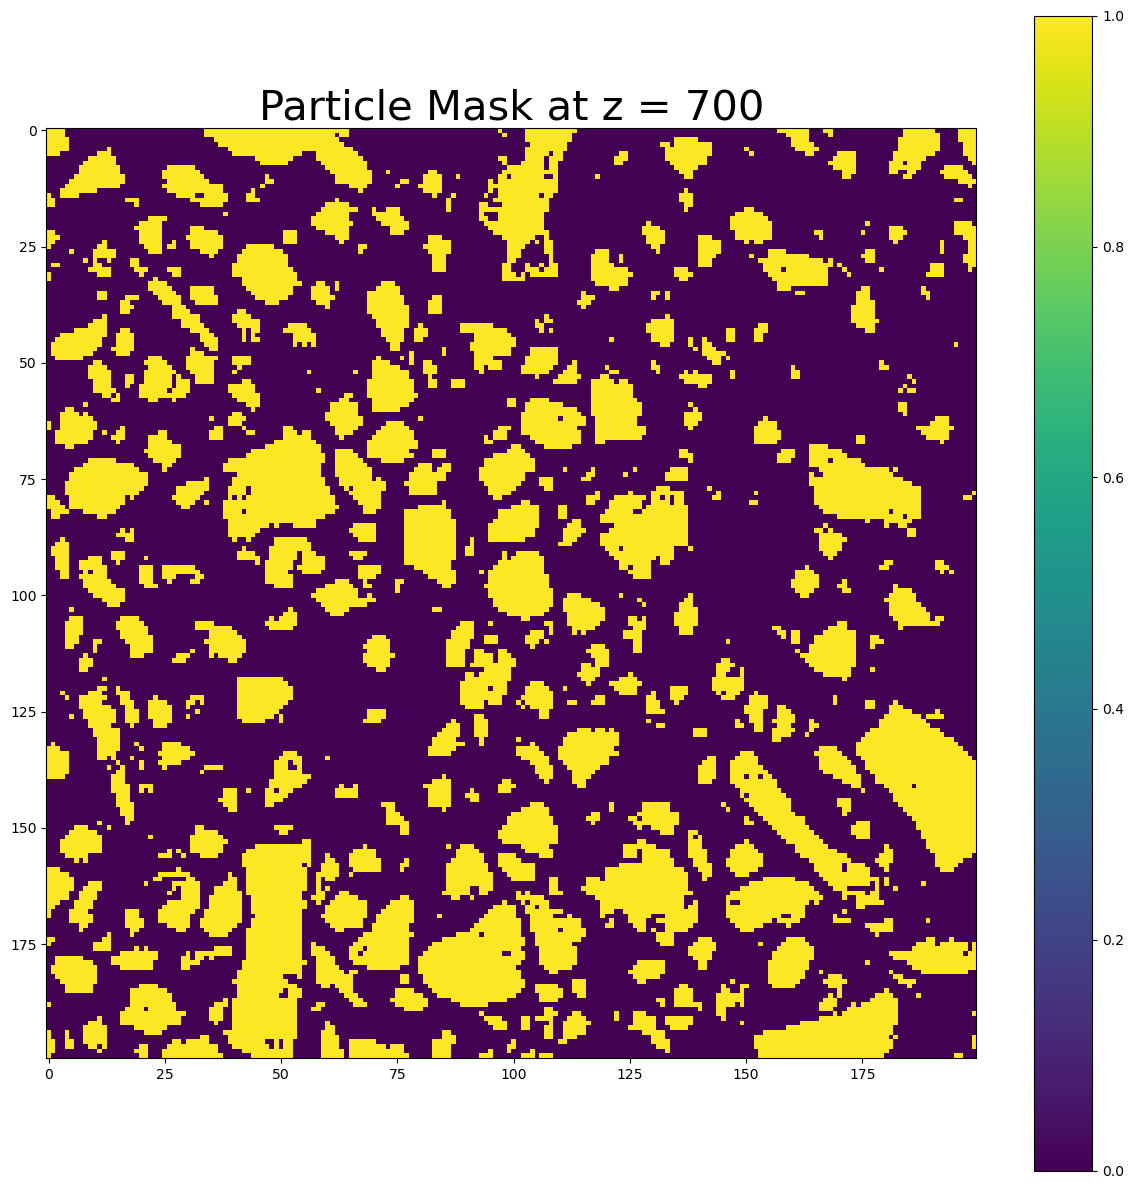

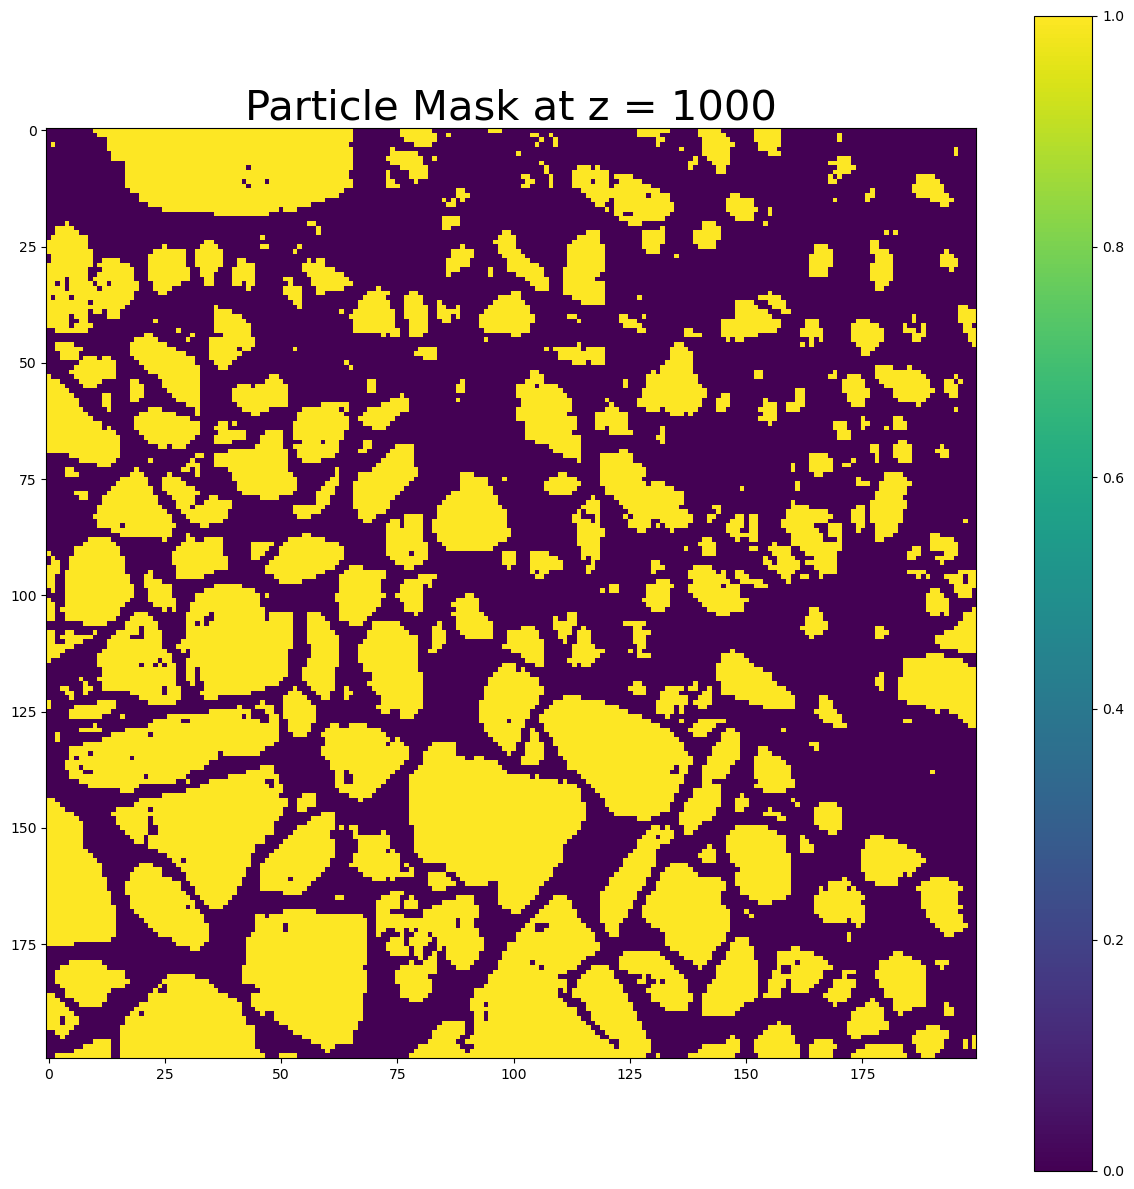

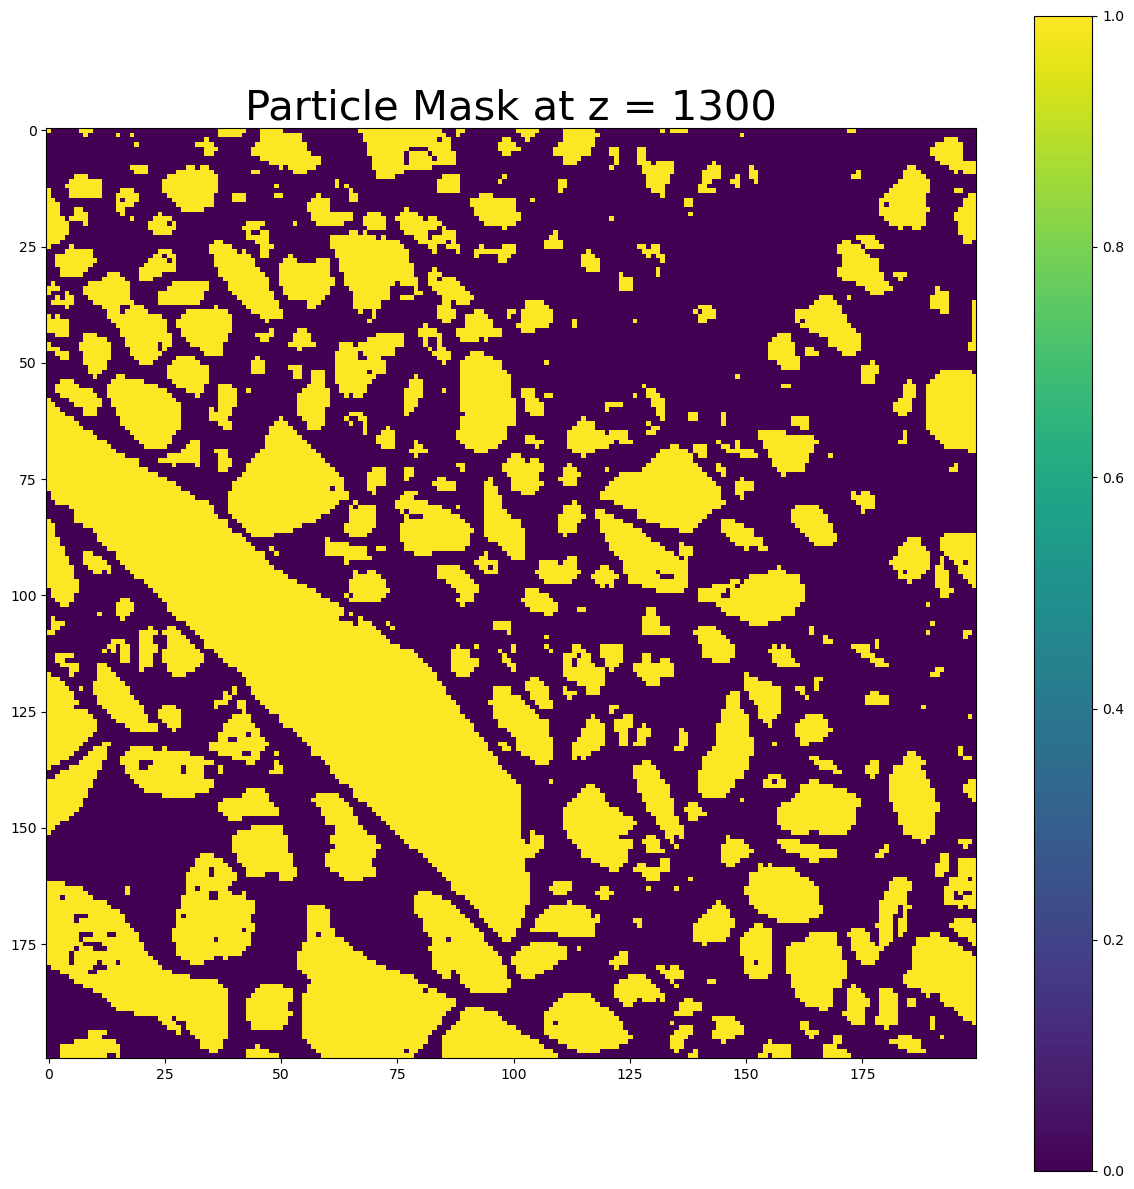

In [7]:
# form a particle mask based on the stored particles
ParticleMask = (cube == 1).astype('uint8')

# plot the grain mask at different z-slices:
# can plot more of these to see how accurate Ilastik was in comparison to raw data
# 0 represents matrix and 1 represents particle

# these masks allow us to quickly analyze the accuracy of the ilastik model
# are the individual grains clear from these grain masks? 
# are there prominent places where grains have not been properly segmented?

plt.figure('Particle Mask (400)', figsize=(15,15))
plt.title('Particle Mask at z = 400', fontsize=30)
plt.imshow(ParticleMask[600:800,600:800,400])
plt.colorbar()
plt.show()

plt.figure('Particle Mask (700)', figsize=(15,15))
plt.title('Particle Mask at z = 700', fontsize=30)
plt.imshow(ParticleMask[600:800,600:800,700])
plt.colorbar()
plt.show()

plt.figure('Particle Mask (1000)', figsize=(15,15))
plt.title('Particle Mask at z = 1000', fontsize=30)
plt.imshow(ParticleMask[600:800,600:800,1000])
plt.colorbar()
plt.show()

plt.figure('Particle Mask (1300)', figsize=(15,15))
plt.title('Particle Mask at z = 1300', fontsize=30)
plt.imshow(ParticleMask[600:800,600:800,1300])
plt.colorbar()
plt.show()

Label every isolated particle:
--------------------------------
The ParticleLabelCube is an np.ndarray that will be used in the rest of the script. This cube represents the 3D data set as segmented particles.

In [13]:
# determine the number of grains in the entire sample by counting individual islands
# needs a lot of memory to run due to extremely large data set
ParticleLabelCube, NumLabel = ndimage.label(ParticleMask, None, output=np.uint32)
print(f'there are {NumLabel} particles that are labeled')

there are 1476494 particles that are labeled


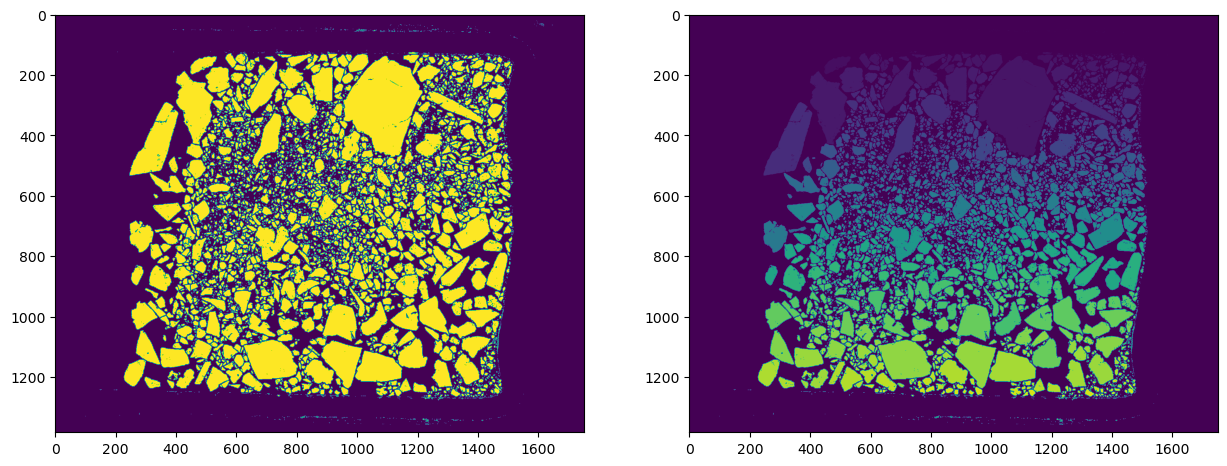

In [15]:
# plot the islands in the entire sample
fig,ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(ParticleMask[:,500,:] == 1)
ax[1].imshow(ParticleLabelCube[:,500,:])
plt.show()

Compute the volume of each particle:
------------------------------------

In [17]:
@njit(parallel=True)     # using numba for speed

def ComputeVolumes(ParticleLabelCube):
    '''
        This function computes the volume of every grain with units of voxels
        input:
            ParticleLabelCube: np.ndarray
                stores the individual particle
        output:
            volumes: np.array
                stores the volume of every particle in ParticleLabelCube
    '''

    # intialize an np.array of size of NumLabel
    volumes = np.zeros(NumLabel)
    # turn np.ndarray to a 1D array
    ParticleRavel = np.ravel(ParticleLabelCube)  

    # loop through every voxel in GrainLabelCube through GrainRavel
    for i in range(len(ParticleRavel)):
        volumes[ParticleRavel[i]] += 1
        
    # first bin is background and is bigger than any other grain
    volumes[0] = 0
    
    return volumes

In [18]:
# assign variable to ComputeVolumes output
volumes = ComputeVolumes(ParticleLabelCube)

In [128]:
# the progress check (updated every 10 particles) said that it had completed 50250 particles
# issue is before (or is) the 50260th particle
print(f"volumes for particles 50250-50260: {volumes[50249:50259]}")

volumes for particles 50250-50260: [ 3. 84.  3.  6.  6.  1.  2.  1.  8. 47.]


In [130]:
# voxel volumes don't seem to be particularly big
# how do they compare to the volumes before?
print(f"largest volume before particle 50250: {np.max(volumes[:50249])}") 

largest volume before particle 50250: 21976.0


In [134]:
# code handles volume of 21976 voxels completely fine
print(f"largest volume of all particles: {np.max(volumes)}")

largest volume of all particles: 11373589.0


Identify the bounding box for every labeled particle:
-----------------------------------------------------------------------------
We use the find_objects function within the ndimage module of the SciPy library. This function identifies each island of voxels (an isolated particle) and returns the coordinates of the bounding box for every labeled particle. The function returns a list of tuples which contain the coordinates.

In [23]:
# assign the bounding boxes to a variable
BoundingBoxes = ndimage.find_objects(ParticleLabelCube)

Use the bounding boxes to approximate the longest axis of every particle:
-------------------------------------------------------------------------

In [25]:
# using a bounding box APPROXIMATION for the longest axis:

def BBLongestAxis(NumLabel, BoundingBoxes):
    '''
        This function calculates an approximation of the longest axis of each particle 
        using a bounding box algorithm
        input:
            NumLabel: 'float'
                the number of labeled particles
            BoundingBoxes: list of tuples
                a list of coordinates for the bounding boxes
        output:
            BBLongestAxes: np.ndarray
                stores an approximated of the longest axis of each particle
    '''

    # initialize an np.array to add longest axes calculations
    BBLongestAxes = np.zeros(NumLabel)

    # loop through each grain's bounding box
    for i, BoundingBox in enumerate(BoundingBoxes):

        # if bounding box is empty, move to the next bounding box
        if BoundingBox is None:
            continue

        # find the bounding box vertex coordinates
        MinCoord = np.array([BoundingBox[j].start for j in range(len(BoundingBox))])
        MaxCoord = np.array([BoundingBox[j].stop for j in range(len(BoundingBox))])

        # find the distance between the two vertex coordinates
        ApproxLongestAxis = np.linalg.norm(MaxCoord - MinCoord)

        # add the approximated axis to np.array
        # multiply value by 0.017 because each voxel is 0.017 mm
        BBLongestAxes[i] = ApproxLongestAxis * 0.017

        # print(f"Grain {i}: approx longest axis = {ApproxLongestAxis if ApproxLongestAxis > 0 else 'N/A'}")

    return BBLongestAxes

In [26]:
# assigning the BBLongestAxis output to a variable
BBLongestAxes = BBLongestAxis(NumLabel, BoundingBoxes)

Compute the actual longest axis of every particle:
-------------------------------------------------

In [ ]:
# counting the grain voxels within a bounding box (NOT an approximation):
# note: requires even more memory than labeling every particle

def LongestAxis(NumLabel, BoundingBoxes):
    '''
        This function calculates the longest axis of each particle by counting the
        euclidean distance between each voxel assigned to the same particle
        input:
            NumLabel: 'float'
                the number of labeled particles
            BoundingBoxes: list of tuples
                a list of coordinates for the bounding boxes
        output:
            LongestAxes: np.ndarray
                stores the longest axis of each particle
    '''
    
    # initialize an array to add largest axes calculations
    LongestAxes = np.zeros(NumLabel)
    
    # loop through each bounding box region
    for i, BoundingBox in enumerate(BoundingBoxes):
    
        # if bounding box is empty, move to the next bounding box
        if BoundingBox is None:
            continue
            
        # define the region of the bounding box
        BoundedRegion = ParticleLabelCube[BoundingBox]
        # find the grain coordinates inside of the bounding box
        ParticleCoord = np.column_stack(np.nonzero(BoundedRegion))
        
        # ignore no voxel grains or grains with only one voxel
        if ParticleCoord.shape[0] <= 1:
            continue
        
        # determine the pairwise distances between every grain voxel in the bounding box
        VoxelDistances = pdist(ParticleCoord, metric='euclidean')

        # loop through every pairwise distance found
        if VoxelDistances.size > 0:  # ensures that there are distances
            LongestAxes[i] = np.max(VoxelDistances) * 0.017  # adds the largest distance to the list of longest axes

        # print(f"Grain {i}: {GrainCoord.shape[0]} voxels, max distance = {np.max(VoxelDistances) if VoxelDistances.size > 0 else 'N/A'}")
    
    return LongestAxes
    

In [54]:
# counting the grain voxels within a bounding box (NOT an approximation):
# note: takes WAY too long

from scipy.spatial.distance import euclidean

def LongestAxis_LessMem(NumLabel, BoundingBoxes):
    '''
        This function calculates the longest axis of each particle by counting the
        euclidean distance between each voxel assigned to the same particle
        input:
            NumLabel: 'float'
                the number of labeled particles
            BoundingBoxes: list of tuples
                a list of coordinates for the bounding boxes
        output:
            LongestAxes: np.ndarray
                stores the longest axis of each particle
    '''
    
    # initialize an array to add largest axes calculations
    LongestAxes = np.zeros(NumLabel)
    
    # loop through each bounding box region
    for i, BoundingBox in enumerate(BoundingBoxes):
    
        # if bounding box is empty, move to the next bounding box
        if BoundingBox is None:
            continue
            
        # define the region of the bounding box
        BoundedRegion = ParticleLabelCube[BoundingBox]
        # find the grain coordinates inside of the bounding box
        ParticleCoord = np.column_stack(np.nonzero(BoundedRegion))
        
        # ignore no voxel grains or grains with only one voxel
        if ParticleCoord.shape[0] <= 1:
            continue

        # initialize the max distance
        MaxDistance = 0
        # loop through the particle voxels within the bounding box
        for j in range(len(ParticleCoord)):
            # loop through all particle voxels that are not j
            for k in range(j + 1, len(ParticleCoord)):
                # find the distance between each particle voxel
                distance = euclidean(ParticleCoord[j], ParticleCoord[k])
                # check if the new distance is greater than the original maximum
                if distance > MaxDistance:
                    # assigning the maximum distance found to the MaxDistance list
                    MaxDistance = distance

        # progress check:
        if i % 10 == 0:
            print(i, end='\r')
    
        # print(f"Grain {i}: {GrainCoord.shape[0]} voxels, max distance = {np.max(VoxelDistances) if VoxelDistances.size > 0 else 'N/A'}")
    
    return LongestAxes


In [56]:
# assigning the LongestAxis output to a variable
LongestAxes = LongestAxis(NumLabel, BoundingBoxes)

# computation is getting stuck near particle 50250 for both methods
# check volumes of these particles ^

KeyboardInterrupt: 

# PLOTTING THE PSFD

Define the power-law function:
-----------------------------

In [58]:
def PowerLaw(x, a, b):
    '''
        This function computes the power law of a given data set
        inputs:
            x: np.array
                the data (longest axes of particles)
            a: float
                the y-intercept of the power-law fit
            b: float
                the slope of the power-law fit
        outputs: 
            PL: float
                the power law
    '''
    
    PL = a * x ** b

    return PL

Determine error:
---------------

In [61]:
# may include in plotting code

# APPROXIMATION:

Plot the approximated PSFD for ilastik:
--------------------------------------

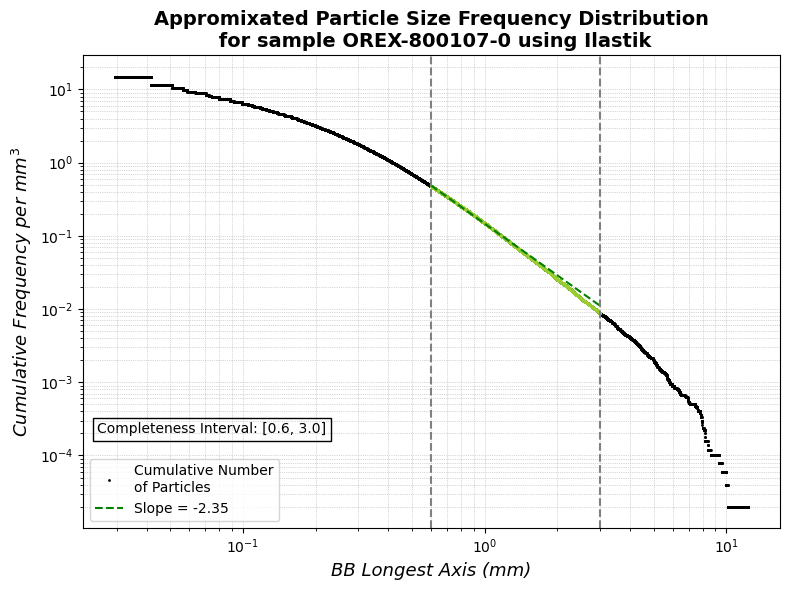

In [108]:
# NO ERROR CALCULATION

# hard-code total analyzed volume of the sample
# used to normalize the counts
SampleVolume = 5e4   # in mm^3

# define the x-range for fitting the linear slope accurately
xmin_fit = 0.6
xmax_fit = 3.0

# create log-spaced bins for histogram plotting
bins = np.logspace(np.log10(min(BBLongestAxes)), np.log10(max(BBLongestAxes)), 10000)
counts, BinEdges = np.histogram(BBLongestAxes, bins=bins)
# determining the cumulative sum from the smallest to the largest particle
CumulativeCounts = np.cumsum(counts[::-1])[::-1] / SampleVolume  # per mm³
BinCenters = (BinEdges[:-1] + BinEdges[1:]) / 2

# ignore zeros in the counts due to loglog space
mask = CumulativeCounts > 0
x = BinCenters[mask]
y = CumulativeCounts[mask]

# mask the data to be within the selected x-range for accurate fitting
# used to find the slope only based on the portion of the plot that is linear
mask2 = (x >= xmin_fit) & (x <= xmax_fit)
x_fit = x[mask2]
y_fit = y[mask2]

# fit the curve to the dataset
parameters, _ = curve_fit(PowerLaw, x_fit, y_fit, p0=[0.12, -2])
a, b = parameters

# compute y=mx+b line for slope
x_line = np.logspace(np.log10(xmin_fit), np.log10(xmax_fit), 100)
y_line = PowerLaw(x_line, a, b)


# plot the PSFD
plt.figure(figsize=(8,6))
plt.loglog(x, y, 'o', ms=1, label='Cumulative Number\nof Particles', color='black')

# highlight portion of the data that contributes to the slope
plt.loglog(x_fit, y_fit, 'o', ms=1, color='yellowgreen')
plt.loglog(x_line, y_line, ls='--', ms=10, label=f"Slope = {b:.2f}", color='green')

# labels and organization
plt.xlabel("BB Longest Axis (mm)", fontsize=13).set_style('italic')
plt.ylabel(f"Cumulative Frequency per $mm^3$", fontsize=13).set_style('italic')
plt.title("Appromixated Particle Size Frequency Distribution\n for sample OREX-800107-0 using Ilastik", fontsize=14, weight='bold')
plt.text(0.025,0.0002,f"Completeness Interval: [{xmin_fit}, {xmax_fit}]", bbox=dict(facecolor='none', edgecolor='black', boxstyle='square'))

plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.axvline(x = xmin_fit, color = 'gray', linestyle='--')
plt.axvline(x = xmax_fit, color = 'gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('PSFD_OREX-800107-0_ilastik_boundingbox.png')
plt.show()

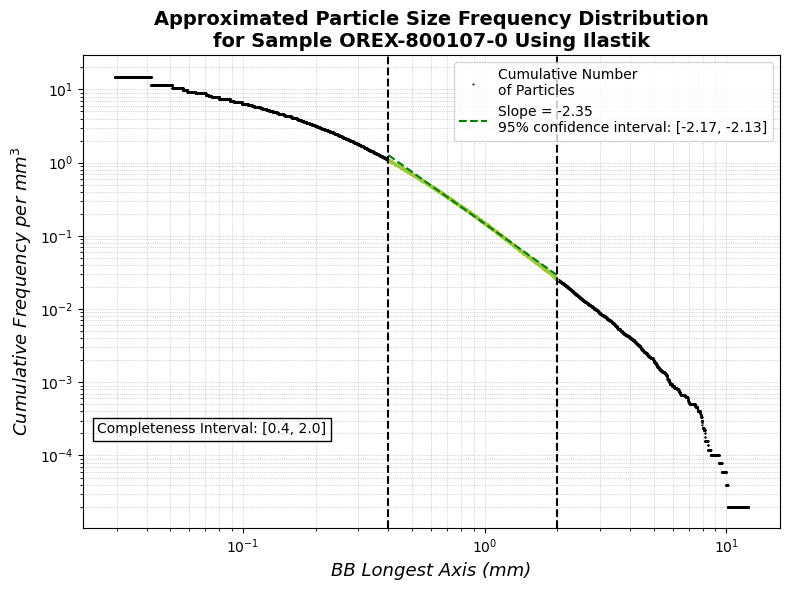

In [110]:
# CALCULATING ERROR WITH BOOTSTRAP METHOD FROM CLAUSSET ET AL.

# hard-code total volume of the sample (approximated)
SampleVolume = 5e4  # in mm^3

# define the x-range for fitting the linear slope accurately
xmin_fit = 0.4
xmax_fit = 2.0

# create log-spaced bins for histogram plotting
bins = np.logspace(np.log10(min(BBLongestAxes)), np.log10(max(BBLongestAxes)), 10000)
BinEdges, _ = np.histogram(BBLongestAxes, bins=bins)
# determine the cumulative sum from the smallest to the largest particle
CumulativeCounts = np.cumsum(BinEdges[::-1])[::-1] / SampleVolume  # per mm³
BinCenters = (bins[:-1] + bins[1:]) / 2

# remove zero counts to avoid log errors
mask = CumulativeCounts > 0
x = BinCenters[mask]
y = CumulativeCounts[mask]

# mask the values for the slope to those previously defined
mask2 = (x >= xmin_fit) & (x <= xmax_fit)
x_fit = x[mask2]
y_fit = y[mask2]

# fit original data to get initial slope
parameteres, _ = curve_fit(PowerLaw, x_fit, y_fit, p0=[0.1, -2.1])
a_fit, b_fit = parameters

# compute the slope line for plotting
x_line = np.logspace(np.log10(xmin_fit), np.log10(xmax_fit), 100)
y_line = PowerLaw(x_line, a_fit, b_fit)

# loop through slope values to find uncertainty
B = 1000  # use at least 5000 for jounral accuracy
BootstrapSlopes = []

for i in range(B):
    # create a randomized data set
    # less biased towards one part of the data
    sample = np.random.choice(BBLongestAxes, size=len(BBLongestAxes), replace=True)
    
    # compute histogram and cumulative counts with randomized data
    bins = np.logspace(np.log10(min(sample)), np.log10(max(sample)), 10000)
    BinEdges, i = np.histogram(sample, bins=bins)
    CumulativeCounts = np.cumsum(BinEdges[::-1])[::-1] / SampleVolume
    BinCenters = (bins[:-1] + bins[1:]) / 2

    # ensure there are no zero counts for log space
    mask3 = CumulativeCounts > 0
    x_bootstrap = BinCenters[mask3]
    y_bootstrap = CumulativeCounts[mask3]

    # ensure the x and y values are within the ranges for best-fit
    mask4 = (x_bootstrap >= xmin_fit) & (x_bootstrap <= xmax_fit)
    x_fit_bootstrap = x_bootstrap[mask4]
    y_fit_bootstrap = y_bootstrap[mask4]

    # try to fit the above power law to the bootstrap data
    try:
        parameters_bootstrap, _ = curve_fit(PowerLaw, x_fit_bootstrap, y_fit_bootstrap, p0=[0.1, -2.1])
        a_bootstrap, b_bootstrap = parameters_bootstrap
        BootstrapSlopes.append(b_bootstrap)
    # if the fit fails, move to the next bootstrap value
    except:
        continue 

# convert list to np array
BootstrapSlopes = np.array(BootstrapSlopes)
mean_slope = np.mean(BootstrapSlopes)
# define confidence intervals
# determine the +/- error for the slope
confidence_lower = np.percentile(BootstrapSlopes, 2.5)  # can change these percentiles
confidence_upper = np.percentile(BootstrapSlopes, 97.5)

# plot the PSFD
plt.figure(figsize=(8, 6))
plt.loglog(x, y, '.', ms=1, label='Cumulative Number\nof Particles', color='black')
# highlight the region of the data that corresponds to the best-fit slope
plt.loglog(x_fit, y_fit, 'o', ms=1, color='yellowgreen')

# plot best fit slope with bootstrap uncertainty
plt.loglog(x_line, y_line, '--', ms=5, 
           label=f"Slope = {b_fit:.2f}\n95% confidence interval: [{confidence_lower:.2f}, {confidence_upper:.2f}]", color='green')

# labels and organization
plt.xlabel('BB Longest Axis (mm)', fontsize=13).set_style('italic')
plt.ylabel('Cumulative Frequency per mm$^3$', fontsize=13).set_style('italic')
plt.title("Approximated Particle Size Frequency Distribution\nfor Sample OREX-800107-0 Using Ilastik", fontsize=14, weight='bold')
plt.text(0.025,0.0002,f"Completeness Interval: [{xmin_fit}, {xmax_fit}]", bbox=dict(facecolor='none', edgecolor='black', boxstyle='square'))
plt.grid(which='both', linestyle=':', linewidth=0.5)
plt.axvline(x = xmin_fit, color = 'black', linestyle='--')
plt.axvline(x = xmax_fit, color = 'black', linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('PSFD_OREX-800107-0_ilastik_boundingbox_bootstrap.png')
plt.show()

Determine the number of particles for each size range (approximated):
-----------------------------------------------------

In [ ]:
# define bins for the particle size range
# 0.01 mm is roughly 1 voxel
bins = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0, 5.0, 12.0]  
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]

# count the number of particles in each bin
counts, _ = np.histogram(BBLongestAxes, bins=bins)

# create table data
table = list(zip(labels, counts))

print(tabulate(table, headers=["Size Range (mm)", "Number of Particles"], tablefmt="simple"))

# ACTUAL:

Plot the actual PSFD for ilastik:
--------------------------------

In [ ]:
# NO ERROR CALCULATION

# hard-code total analyzed volume of the sample
# used to normalize the counts
SampleVolume = 5e4   # in mm^3

# define the x-range for fitting the linear slope accurately
xmin_fit = 0.3
xmax_fit = 5.0

# create log-spaced bins for histogram plotting
bins = np.logspace(np.log10(min(LongestAxes)), np.log10(max(LongestAxes)), 10000)
counts, BinEdges = np.histogram(LongestAxes, bins=bins)
# determining the cumulative sum from the smallest to the largest particle
CumulativeCounts = np.cumsum(counts[::-1])[::-1] / SampleVolume  # per mm³
BinCenters = (BinEdges[:-1] + BinEdges[1:]) / 2

# ignore zeros in the counts due to loglog space
mask = CumulativeCounts > 0
x = BinCenters[mask]
y = CumulativeCounts[mask]

# mask the data to be within the selected x-range for accurate fitting
# used to find the slope only based on the portion of the plot that is linear
mask2 = (x >= xmin_fit) & (x <= xmax_fit)
x_fit = x[mask2]
y_fit = y[mask2]

# fit the curve to the dataset
parameters, _ = curve_fit(PowerLaw, x_fit, y_fit, p0=[0.12, -2])
a, b = parameters

# compute y=mx+b line for slope
x_line = np.logspace(np.log10(xmin_fit), np.log10(xmax_fit), 100)
y_line = PowerLaw(x_line, a, b)

# plot the PSFD
plt.figure(figsize=(8,6))
plt.loglog(x, y, 'o', ms=1, label='Cumulative Number\nof Particles', color='black')
# highlight portion of the data that contributes to the slope
plt.loglog(x_fit, y_fit, 'o', ms=1, color='yellowgreen')
plt.loglog(x_line, y_line, ls='--', ms=10, label=f"Slope = {b:.2f}", color='green')
# labels and organization
plt.xlabel("Longest Axis (mm)", fontsize=13).set_style('italic')
plt.ylabel(f"Cumulative Frequency per $mm^3$", fontsize=13).set_style('italic')
plt.title("Particle Size Frequency Distribution\n for sample OREX-800107-0 using Ilastik", fontsize=14, weight='bold')
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.axvline(x = xmin_fit, color = 'black', linestyle='--')
plt.axvline(x = xmax_fit, color = 'black', linestyle='--')
plt.legend()
plt.tight_layout()
plt.savefig('PSFD_OREX-800107-0_ilastik.png')
plt.show()

Determine the number of particle of each size range (actual):
---------------------------------------------------

In [ ]:
# define bins for the particle size range
bins = [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 2.0, 3.0, 5.0, 7.0]  
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]

# count the number of particles in each bin
counts, _ = np.histogram(LongestAxes, bins=bins)

# create table data
table = list(zip(labels, counts))

print(tabulate(table, headers=["Size Range (mm)", "Number of Particles"], tablefmt="simple"))